<a href="https://colab.research.google.com/github/miller00315/ia_studies/blob/main/pytorch_custom_dataset_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Pytroch Custom dataset

## 0. Import PyTorch and setting up agnostic device

In [1]:

import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
import os
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


## 1. Get data

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Download pizza data if it doesn't exist

if image_path.is_dir():
    print(f"Image directory exists {image_path}")
else:
    print(f"Image directory does not exist {image_path}")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi dta
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

Image directory does not exist data/pizza_steak_sushi
Unzipping pizza, steak, sushi data...


## 2. Becomming one with the data

In [4]:
import os

def walk_through_dir(dir_path):

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [5]:
# Setup train and testing paths

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing a image

Random image path: data/pizza_steak_sushi/train/steak/355715.jpg
Image height: 382
Image width: 512


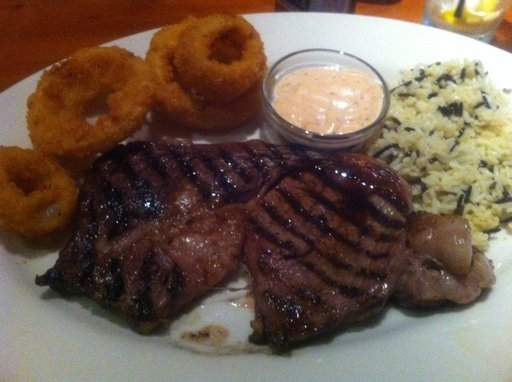

In [6]:
import random
from PIL import Image

random.seed(42)

#1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

#2. Pick a random image path
random_image = random.choice(image_path_list)

image_class = random_image.parent.stem

#3. Pick a random image path
img = Image.open(random_image)

print(f"Random image path: {random_image}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

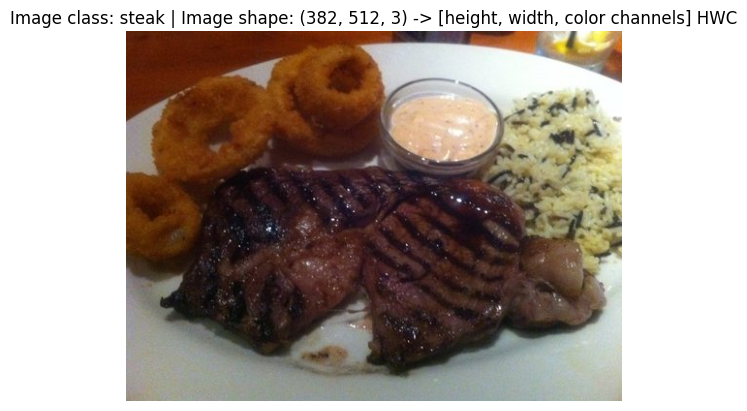

In [7]:
import numpy as np
import matplotlib.pyplot as plt

image_as_array = np.array(img)

plt.imshow(image_as_array)
plt.title(f"Image class: {image_class} | Image shape: {image_as_array.shape} -> [height, width, color channels] HWC")
plt.axis(False);


## 3. Transforming data

### 3.1 Transformin dta with `torchvision.transforms`

In [8]:
data_transform = transforms.Compose([
    transforms.Resize((64, 64)), # Resize our images
    transforms.RandomHorizontalFlip(p=0.5), # Flipe the images randomly
    transforms.ToTensor() # Turn image into a torch tensor
])

In [9]:
data_transform(img).shape

torch.Size([3, 64, 64])

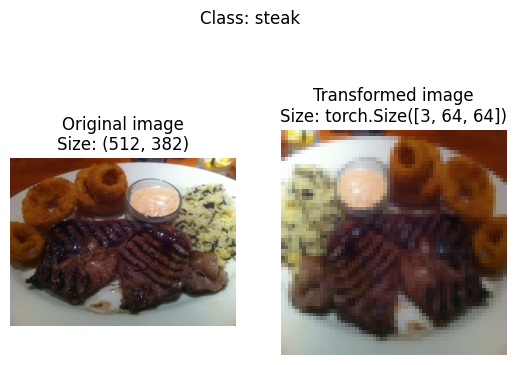

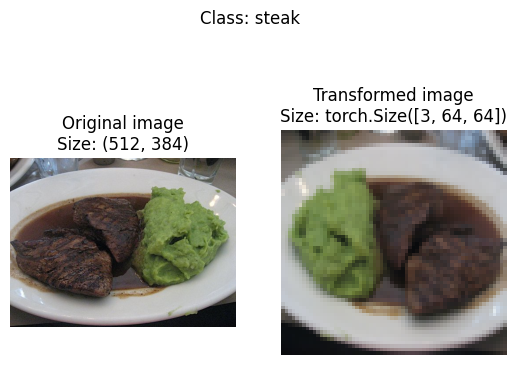

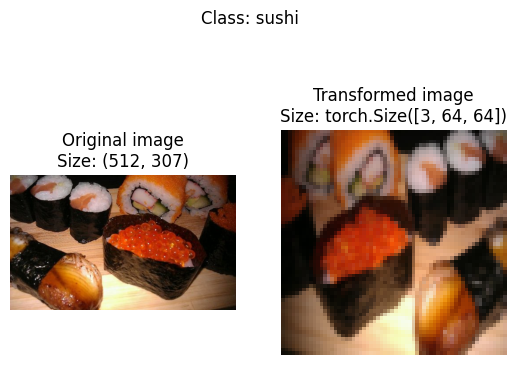

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original image\nSize: {f.size}")
      ax[0].axis(False)

      transformed_img = transform(f) # Note we will need to change shape
      ax[1].imshow(transformed_img.permute(1, 2, 0)) # Note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].set_title(f"Transformed image\nSize: {transformed_img.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}")
      plt.show()

plot_transformed_images(
    image_paths=image_path_list,
    transform=data_transform,
    n=3,
    seed=42
  )

## 4. Loaging images using `ImageFolder`

In [11]:
# Use IMageFolder to create datset(s)

from torchvision import datasets

train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,
    target_transform=None
  )

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform,
    target_transform=None
  )

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [12]:
# Get class names as list

class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
# Get class names as dict

class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
len(train_data), len(test_data)

(225, 75)

In [15]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [16]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]

print(f"Image tensor: zn{img}")
print(f"Image shape: {img.shape}")
print(f"Image data type: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor: zntensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.

In [17]:
class_names[label]

'pizza'

Image shape: torch.Size([3, 64, 64])
Image permute shape: torch.Size([64, 64, 3])


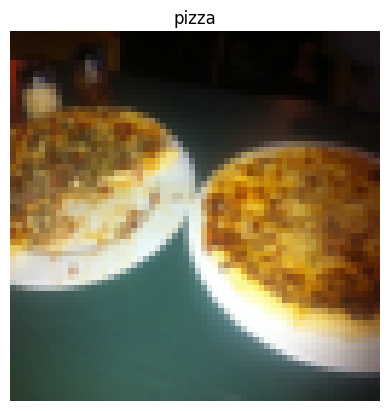

In [18]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# print out different shapes
print(f"Image shape: {img.shape}")
print(f"Image permute shape: {img_permute.shape}")

plt.imshow(img_permute)
plt.title(class_names[label])
plt.axis(False);

## 4.1 Tund loaded images into `DataLoaders`

In [19]:
import os

os.cpu_count()

2

In [20]:
# Turn train and test datasets into DataLoaser's

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78119ede77c0>,
 <torch.utils.data.dataloader.DataLoader at 0x78119ede6dd0>)

In [21]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [22]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [23]:
from typing import Tuple, Dict, List

# Instance of torchvision.datasets.ImageFolder()
train_data.classes, test_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

In [24]:
# Setup path for target directory
target_directory = train_dir

print(f"target dir: {target_directory}")

class_names_found = sorted([item.name for item in (os.scandir(target_directory))])
class_names_found

target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [25]:
list(os.scandir(target_directory))

[<DirEntry 'steak'>, <DirEntry 'sushi'>, <DirEntry 'pizza'>]

In [26]:
def find_classes(target_directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Find the classes folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(target_directory) if entry.is_dir())

  # 2 Raise an erro if class name could not be found
  if not classes:
    raise FileNotFoundError(f"Could not find any classes in {target_directory}.. please check file structure")

  # Create a dictionary of index labels (computers prefer numbers rather thna strings as labels)
  class_to_idx = {class_name: item for item, class_name in enumerate(classes)}

  return classes, class_to_idx

In [27]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

In [28]:
# 0. Write a custom dataset class
import pathlib

# 1. Subclass torch.uitls.data.Dataset
class ImageFolderCustom(Dataset):
  # 2.initialize our custom dataset
  def __init__(
      self,
      target_dir: str,
      transform=None):
    # 3. Create class attibutes
    # Get all of the image paths
    self.target_dir = target_dir
    self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx
    self.classes, self.class_to_idx = find_classes(target_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens a image by a path and returns it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total numbers of samples."
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, dta and lable (X, y)."
    img = self.load_image(index)

    class_name = self.paths[index].parent.name # expects path in format: dta_folder/class_name/image.jpg

    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)

    return img, class_idx # return untransfomed data, label(X, y)


In [29]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't flip or manipulate test data
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [30]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(target_dir=train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(target_dir=test_dir, transform=test_transforms)

In [31]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x78119ee03c40>,
 <__main__.ImageFolderCustom at 0x78119ee032b0>)

In [32]:
len(train_data), len(train_data_custom)

(225, 225)

In [33]:
len(test_data), len(test_data_custom)

(75, 75)

In [34]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [35]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
assert train_data.classes == train_data_custom.classes
assert train_data.class_to_idx == train_data_custom.class_to_idx

### 5.3 Create a function to display random images

In [36]:
# 1. Create a function to take in a adataset
def display_random_images(
    dataset: torch.utils.data.Dataset,
    classes: List[str] = None,
    n: int = 10,
    display_shape: bool = True,
    seed: int = None):
  """Display a random selection of images from a dataset."""
  # 2. Adjust display if n is too high
  if n > 10:

    n = 10

    display_shape = False

    print("For display, purposes, 'n' shouldn't be larger than 10, setting to 10 and removing shape display")

  # 3. Setup random seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setuo plot
  plt.figure(figsize=(16, 6))

  # 6. Loop through radom index and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for ploting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # 8. Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")

    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title += f"\nShape: {targ_image_adjust.shape}"
      plt.title(title)

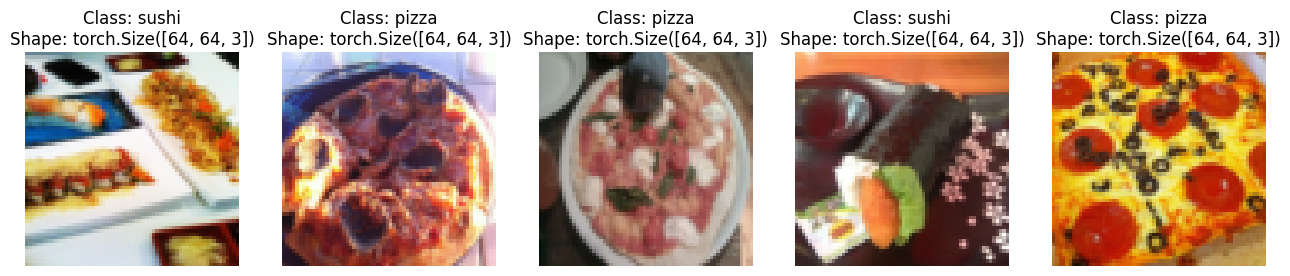

In [37]:
# Disply random images from the ImageFolder
display_random_images(dataset=train_data, classes=train_data.classes, n=5, seed=42)

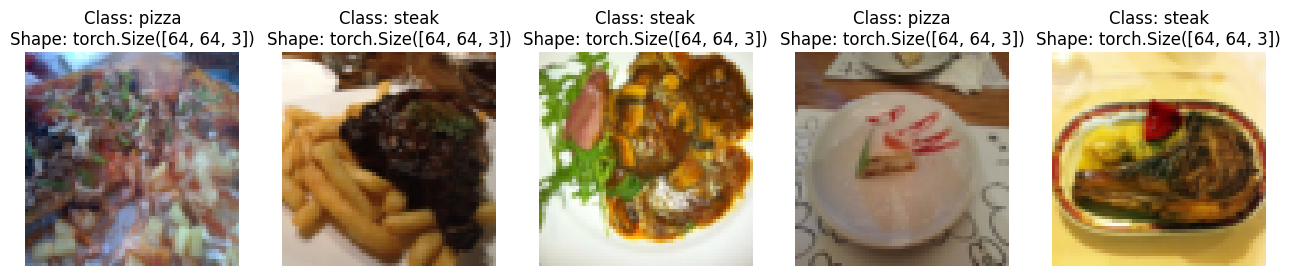

In [38]:
# Disply random image from the ImageFolderCustom Dataset
display_random_images(dataset=train_data_custom, classes=train_data_custom.classes, n=5, seed=42)

### 5.4 Turn custom loaded into `DataLoaser`s

In [39]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(
    dataset=train_data_custom,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

test_dataloader_custom = DataLoader(
    dataset=test_data_custom,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False # Don't shuffle the test data
)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x78119e2697b0>,
 <torch.utils.data.dataloader.DataLoader at 0x78119e259960>)

In [40]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 6. Other forms of transforoms (data augmetation)


In [41]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
    ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
  ])

In [42]:
# Get al image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/train/steak/1849463.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/97656.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1264154.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2881783.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/735441.jpg')]

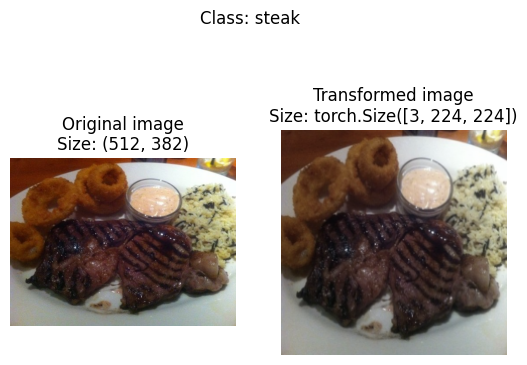

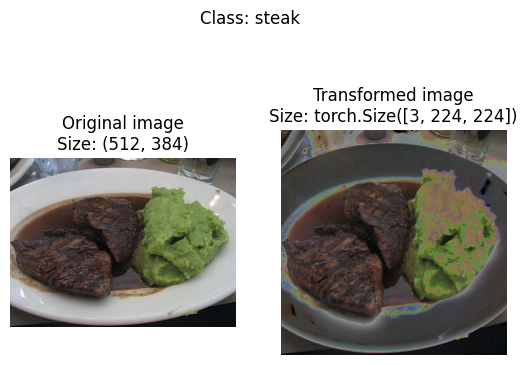

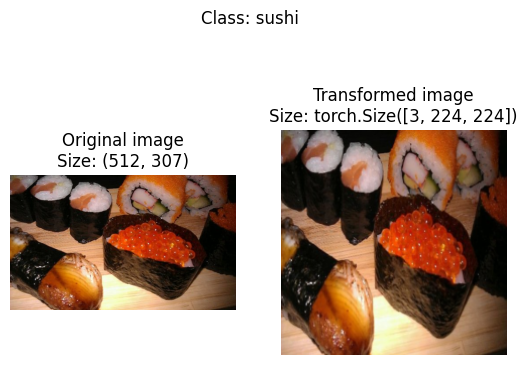

In [43]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=42
)


## 7. Model 0: TinyGG without data augmentation

### 71. Creating transforms and loading data for Model 0

In [44]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [45]:
# 1. Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(
    root=train_dir,
    transform=simple_transform
)

test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=simple_transform
)

# 2. Turn teh dtasets into DataLoaders

import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create dataLoader's
train_dataloader_simple = DataLoader(
    dataset=train_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
  )

test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
  )


### 7.2 Create TinyVGG model class

In [46]:
class TinyVGG(nn.Module):
  """
    Model architecture copynig TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
  """
  def __init__(
            self,
            input_shape: int,
            hidden_units: int,
            output_shape: int
          ):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3, # how big is the square that's going over the image?
                    stride=1, # default
                    padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2) # default stride value is same as kernel_size
      )

    self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )

    self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from?
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*16*16,
                    out_features=output_shape)
      )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion


https://horace.io/brrr_intro.html

In [47]:
torch.manual_seed(42)
model_0 = TinyVGG(
    input_shape=3, # number of color channels in our image data
    hidden_units=10, #
    output_shape=len(class_names)
  ).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a foward pass on a single image

In [48]:
# get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))

image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [49]:
# try a foward pass

model_0(image_batch.to(device))[:2]

tensor([[0.0578, 0.0634, 0.0351],
        [0.0657, 0.0650, 0.0398]], grad_fn=<SliceBackward0>)

### 7. Use `torchinfo` to get a idea to teh shapes going through the model

In [50]:
# Instla torchinfo, inport if it's available
try:
  from torchinfo import summary
except ModuleNotFoundError:
  !pip install torchinfo
  from torchinfo import summary
  print("[INFO] torchinfo not found, installing it...")

[INFO] torchinfo not found, installing it...


In [51]:
summary(model=model_0, input_size=image_batch.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

In [52]:
# Download helper funcitons

### 7.5 Create train and tes loop functions

In [53]:
# Create train step
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  """Performs a training with model trying to learn on data loader."""
  # Put the model in train mode
  model.train()

  # Set train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through dta loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to th target device
    X, y = X.to(device), y.to(device)

    # 1. Forwar pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate the accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [54]:
# Create test step
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device):
  """Performs a testing with model trying to learn on data loader."""
  # Put the model in test mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference mode
  with torch.inference_mode():
    for X, y in dataloader:
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model_0(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_preds_class = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      test_acc += (test_preds_class == y).sum().item()/len(test_preds_class)

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

### 7.6 Creating a trinn function to combine `train_step` with `test_step`

In [55]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in vatious model parameters

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    device = device,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 5,
):
  """Trains and tests a PyTorch model."""
  # 2. Create empty results
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop thorugh training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
        model=model,
        dataloader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device
    )

    test_loss, test_acc = test_step(
        model=model,
        dataloader=test_dataloader,
        loss_fn=loss_fn,
        device=device
    )

    # 4. Print out what's happening
    print(
        f"""Epoch: {epoch+1} |
        Train, loss: {train_loss:.4f}, acc: {train_acc:.4f} | Train_acc: {train_acc:.4f} |
        Test_loss: {test_loss:.4f} | Test_acc: {test_acc:.4f}""")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

### 7.7 Train and evaluate model 0

In [56]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup number of epochs
NUM_EPOCHS = 5

# Recreate a intance of TinyVGG
model_0 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

# Setup loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train and test model
model_0_results = train(
    model=model_0,
    train_dataloader=train_dataloader_simple,
    test_dataloader=test_dataloader_simple,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device
)

# End the timer and print out how long it took
end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | 
        Train, loss: 1.0975, acc: 0.2500 | Train_acc: 0.2500 | 
        Test_loss: 1.1055 | Test_acc: 0.1979
Epoch: 2 | 
        Train, loss: 1.0968, acc: 0.3984 | Train_acc: 0.3984 | 
        Test_loss: 1.1072 | Test_acc: 0.1979
Epoch: 3 | 
        Train, loss: 1.0983, acc: 0.2930 | Train_acc: 0.2930 | 
        Test_loss: 1.1082 | Test_acc: 0.1875
Epoch: 4 | 
        Train, loss: 1.0963, acc: 0.3828 | Train_acc: 0.3828 | 
        Test_loss: 1.1099 | Test_acc: 0.1979
Epoch: 5 | 
        Train, loss: 1.0971, acc: 0.2930 | Train_acc: 0.2930 | 
        Test_loss: 1.1109 | Test_acc: 0.1667
Total training time: 19.874 seconds


In [57]:
model_0_results


{'train_loss': [1.0975299775600433,
  1.0967943370342255,
  1.0983306169509888,
  1.0963324457406998,
  1.0971065163612366],
 'train_acc': [0.25, 0.3984375, 0.29296875, 0.3828125, 0.29296875],
 'test_loss': [1.1055066188176472,
  1.1072301864624023,
  1.1081714232762654,
  1.1098816792170207,
  1.110876242319743],
 'test_acc': [0.19791666666666666,
  0.19791666666666666,
  0.1875,
  0.19791666666666666,
  0.16666666666666666]}

### 7.8 Plot the loss curves of model 0

In [58]:
# get the model_0_results keys

model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [59]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training and test loss curves."""
  # Get the loss values of

  loss = results["train_loss"]
  val_loss = results["test_loss"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Plot loss
  plt.figure(figsize=(15, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, val_loss, label="test_loss")
  plt.title("Training and test loss curves")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

  # Get accuracy
  acc = results["train_acc"]
  val_acc = results["test_acc"]

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, label="train_acc")
  plt.plot(epochs, val_acc, label="test_acc")
  plt.title("Training and test accuracy curves")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

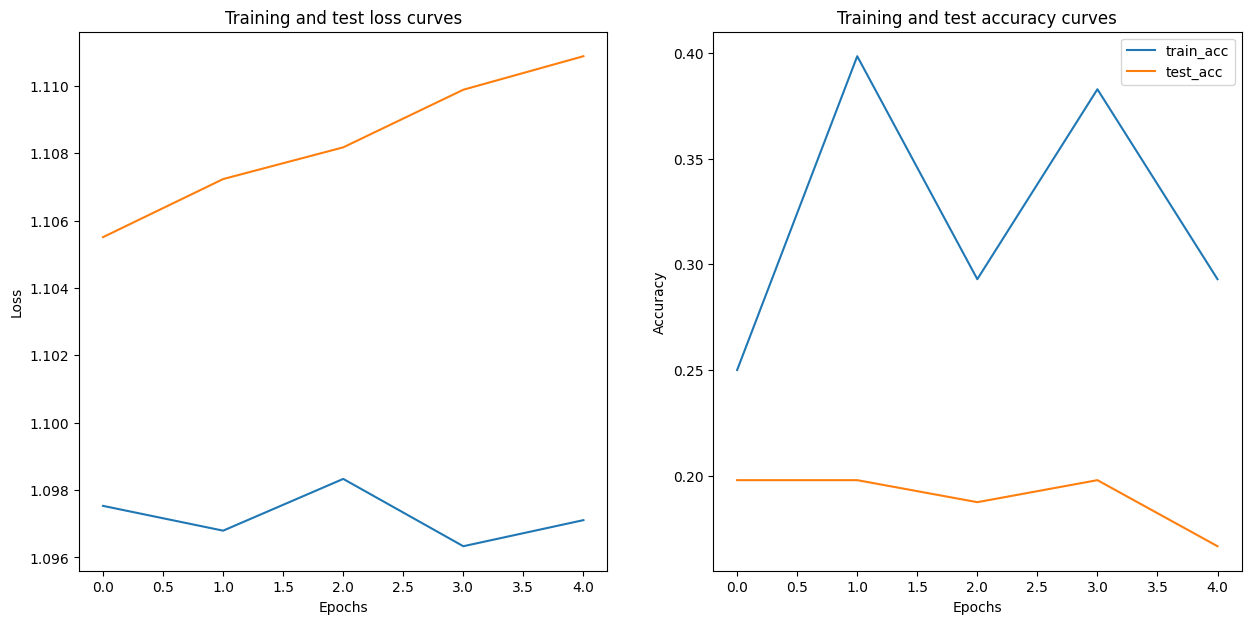

In [60]:
plot_loss_curves(model_0_results)

## 8. What should an idela loss curve look like?

## 9. TinyVGG with augmented data

In [66]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`s and `Dataloader`s with data augmentation

In [67]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [68]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78119f026da0>,
 <torch.utils.data.dataloader.DataLoader at 0x78119ede6dd0>)

### 9.1 Construct and train model 1

In [69]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [70]:
# Set random seeds
torch.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | 
        Train, loss: 1.1076, acc: 0.2500 | Train_acc: 0.2500 | 
        Test_loss: 1.1109 | Test_acc: 0.1667
Epoch: 2 | 
        Train, loss: 1.0791, acc: 0.4258 | Train_acc: 0.4258 | 
        Test_loss: 1.1109 | Test_acc: 0.1667
Epoch: 3 | 
        Train, loss: 1.0810, acc: 0.4258 | Train_acc: 0.4258 | 
        Test_loss: 1.1109 | Test_acc: 0.1667
Epoch: 4 | 
        Train, loss: 1.1292, acc: 0.3047 | Train_acc: 0.3047 | 
        Test_loss: 1.1109 | Test_acc: 0.1667
Epoch: 5 | 
        Train, loss: 1.0899, acc: 0.4258 | Train_acc: 0.4258 | 
        Test_loss: 1.1109 | Test_acc: 0.1667
Total training time: 12.147 seconds


### 9.4 Plt the loss curves of mdoel 1

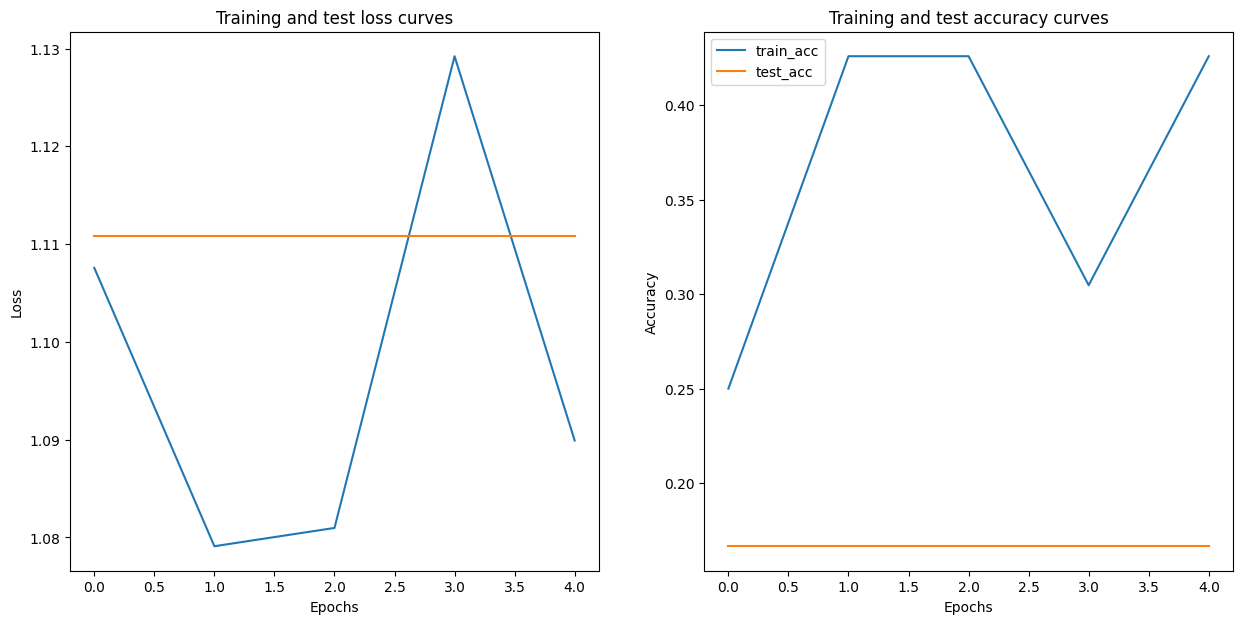

In [71]:
plot_loss_curves(model_1_results)

## 10. Compare models results

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

In [78]:
model_0_df.head()

,train_loss,train_acc,test_loss,test_acc
0,1.097530,0.250000,1.105507,0.197917
1,1.096794,0.398438,1.107230,0.197917
2,1.098331,0.292969,1.108171,0.187500
3,1.096332,0.382812,1.109882,0.197917
4,1.097107,0.292969,1.110876,0.166667


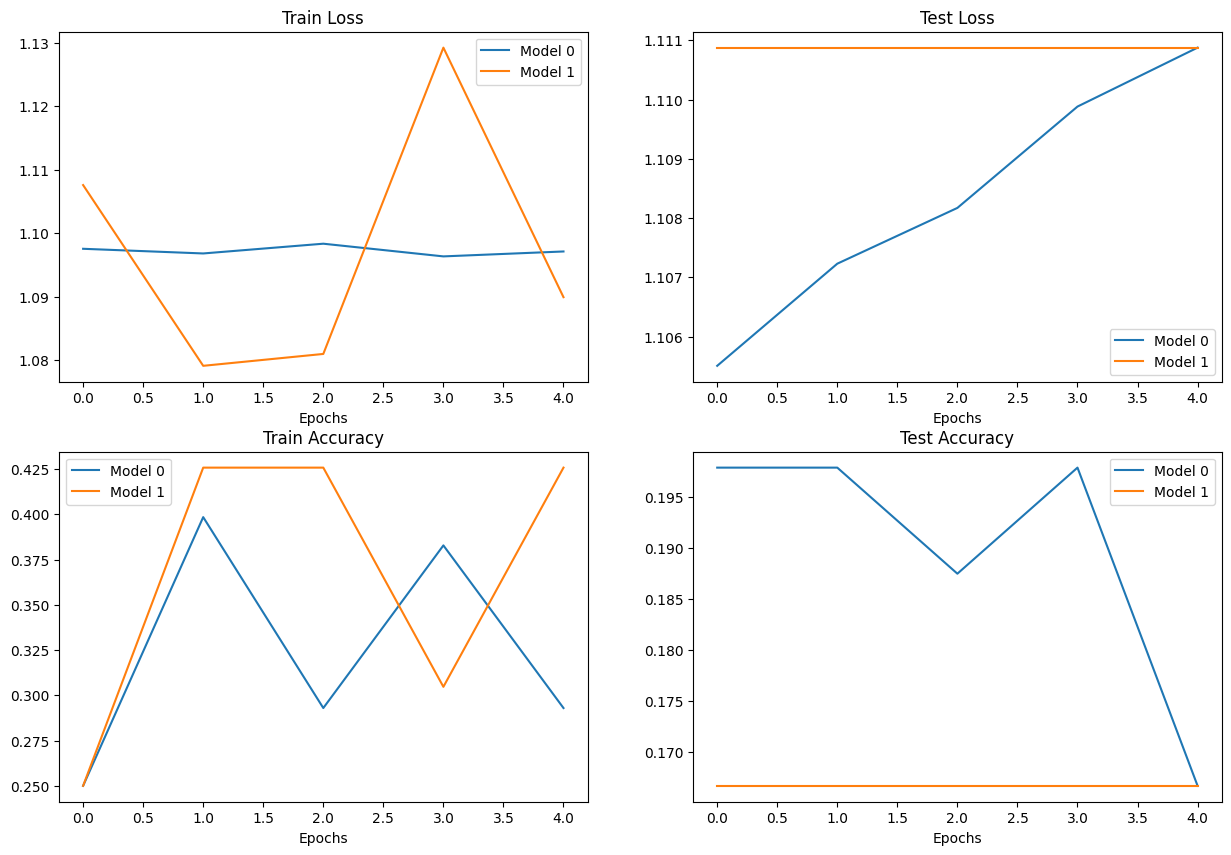

In [87]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

In [88]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [89]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

In [90]:
# Try to make a prediction on image in uint8 format (this will error)
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [91]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

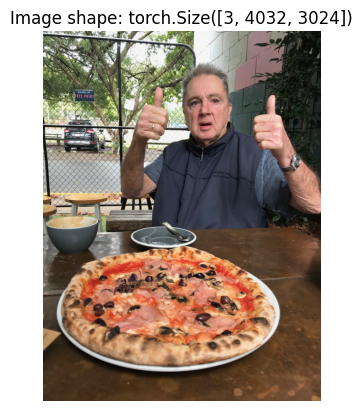

In [92]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [93]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [94]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

In [95]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

In [96]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [97]:
custom_image_pred

tensor([[ 0.1188,  0.0339, -0.1486]])

In [98]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1188,  0.0339, -0.1486]])
Prediction probabilities: tensor([[0.3726, 0.3422, 0.2852]])
Prediction label: tensor([0])


In [99]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

In [100]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[0.3726, 0.3422, 0.2852]])

In [101]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

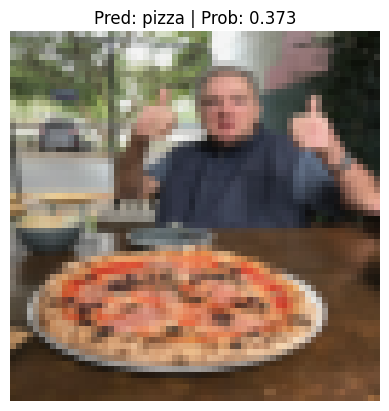

In [102]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)